# ALL HINDI
## 2-ways n-shots
ResNet50V2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras

In [ ]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import ResNet50V2


import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # Check if the image is empty or None
    if image is None or len(image) == 0:
        print(f"Error: Image {img_path} is empty or None.")
        return None

    # Check if the image has valid dimensions
    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} has invalid dimensions.")
        return None

    # Resize image
    image = cv2.resize(image, (img_h, img_w))

    # Convert grayscale to RGB by replicating the channel
    image = cv2.merge((image, image, image))

    # Normalize pixel values
    image = image.astype('float32') / 255.0
    return image

# Function to generate batches
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            # Preprocess images using preprocess_image function
            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            # Assign preprocessed images to pairs
            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Load and preprocess data
path = "/content/drive/MyDrive/Multilingual dataset/HINDI"
dir_list = next(os.walk(path))[1]

orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:24])
    orig_groups.append(images[24:])

# Split data into train, validation, and test sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Define Siamese network model with ResNetV2 base
def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add GlobalAveragePooling2D layer to reduce dimensions
    base_model = Sequential([
        base_model,
        GlobalAveragePooling2D()
    ])

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_a, processed_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

# Compile model
input_shape = (img_h, img_w, 3)  # Adjusted input shape for RGB
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08))

# Define callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/Hindi-Weights/hindi-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
batches_per_epoch_train = num_train_samples // batch_size
batches_per_epoch_val = num_val_samples // batch_size

# Calculate steps per epoch
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,  # Use calculated steps per epoch
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,  # Use calculated steps per epoch for validation
    callbacks=callbacks
)


94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 0.2129 
Epoch 1: val_loss improved from inf to 2.00616, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-001.h5
66/66 [==============================] - 1134s 17s/step - loss: 0.2129 - val_loss: 2.0062 - lr: 1.0000e-04
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.0026 
Epoch 2: val_loss improved from 2.00616 to 0.60429, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-002.h5
66/66 [==============================] - 998s 15s/step - loss: 0.0026 - val_loss: 0.6043 - lr: 1.0000e-04
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 9.5529e-05 
Epoch 3: val_loss improved from 0.60429 to 0.44134, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Cedar-Weights/cedar-003.h5
66/66 [==============================] - 953s 14s/step -

In [ ]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/Hindi-Weights/hindi-005.h5')

In [ ]:
# Test model
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions > optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

1/1 [==============================] - 11s 11s/step
Accuracy: 0.90625
Precision: 1.0
Recall: 0.8125
F1-Score: 0.896551724137931


In [ ]:
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

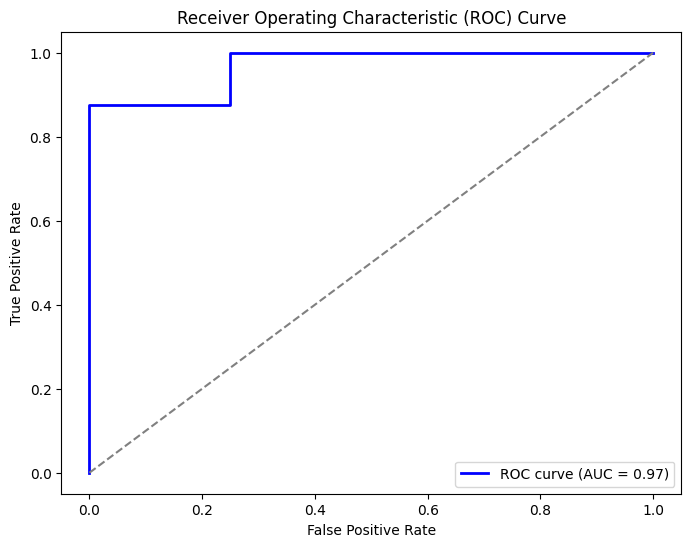

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)


Originals:
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_1.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_10.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_11.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_12.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_13.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_14.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_15.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_16.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_17.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_18.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_19.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_2.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/original_41_20.png
/content/drive/MyDrive/Multilingual dataset/CEDAR/41/or

In [ ]:
# Print the test batch inputs, predictions, and labels
print("Test Batch Inputs:")
print(test_batch_inputs)
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)


Test Batch Inputs:
[array([[[[0.92941177, 0.92941177, 0.92941177],
         [0.93725491, 0.93725491, 0.93725491],
         [0.94901961, 0.94901961, 0.94901961],
         ...,
         [0.95686275, 0.95686275, 0.95686275],
         [0.95686275, 0.95686275, 0.95686275],
         [0.93725491, 0.93725491, 0.93725491]],

        [[0.93333334, 0.93333334, 0.93333334],
         [0.9254902 , 0.9254902 , 0.9254902 ],
         [0.93333334, 0.93333334, 0.93333334],
         ...,
         [0.95294118, 0.95294118, 0.95294118],
         [0.95294118, 0.95294118, 0.95294118],
         [0.95294118, 0.95294118, 0.95294118]],

        [[0.9254902 , 0.9254902 , 0.9254902 ],
         [0.91764706, 0.91764706, 0.91764706],
         [0.94901961, 0.94901961, 0.94901961],
         ...,
         [0.95294118, 0.95294118, 0.95294118],
         [0.96078432, 0.96078432, 0.96078432],
         [0.95686275, 0.95686275, 0.95686275]],

        ...,

        [[0.93333334, 0.93333334, 0.93333334],
         [0.9254902 , 0.9

1/1 [==============================] - 6s 6s/step


<ipython-input-37-0ea14a70b1f6>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


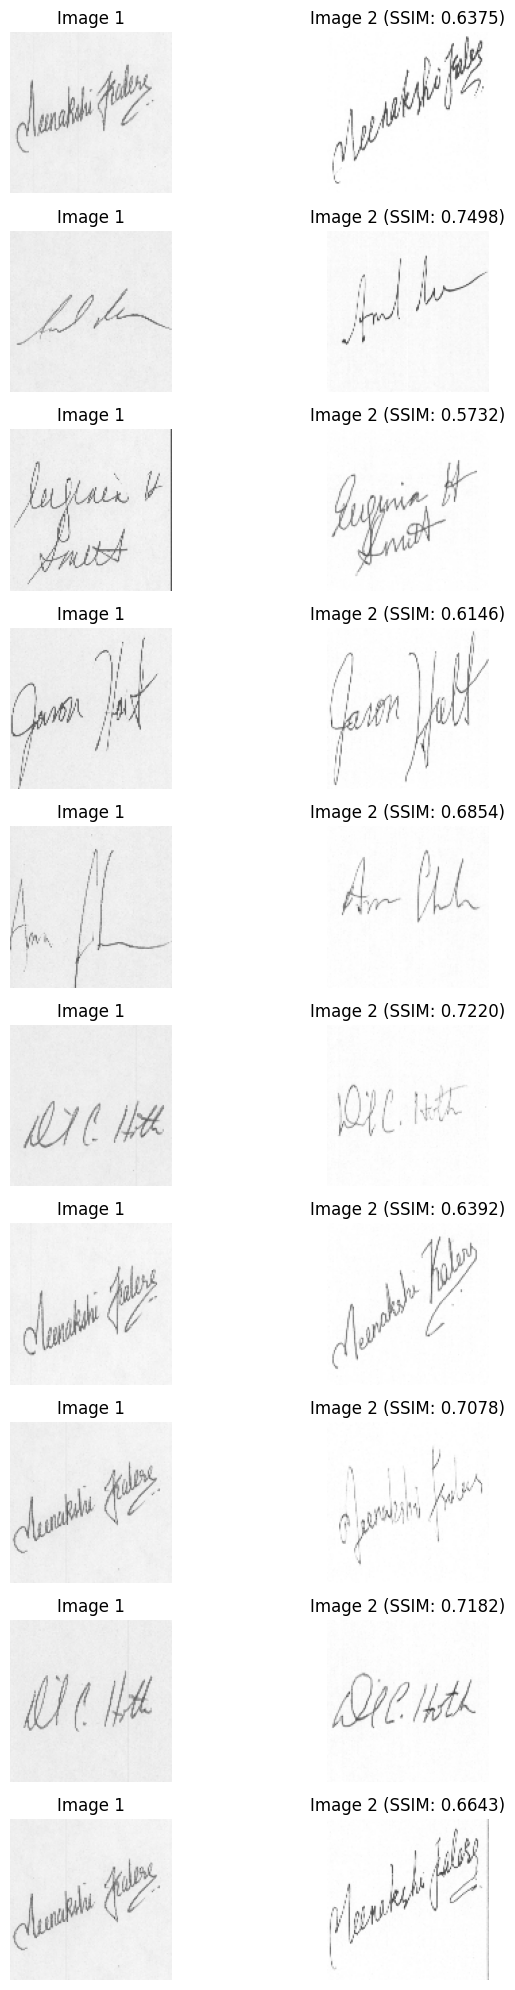

In [ ]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    ssim_scores = []
    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        ssim_scores.append(ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores and print the average SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)